In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wider table display so columns don't wrap
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)

# Path to CSV (relative to this notebook inside /notebooks/)
DATA_PATH = "../data/raw/telco_churn.csv"

# Sanity checks
assert os.path.exists(DATA_PATH), f"CSV not found: {os.path.abspath(DATA_PATH)}"
print("OK: imports loaded and CSV path exists")
print("Python exe:", sys.executable)
print("CWD:", os.getcwd())

OK: imports loaded and CSV path exists
Python exe: C:\Users\amobi\churn-prediction\.venv\Scripts\python.exe
CWD: C:\Users\amobi\churn-prediction\notebooks


In [2]:
# --- Load the CSV ---
df = pd.read_csv(DATA_PATH)

# Normalise column names (trim accidental spaces)
df.columns = [c.strip() for c in df.columns]

# --- First look ---
print("Shape:", df.shape)             # (rows, cols)
print("\nColumns (first 12):", df.columns[:12].tolist())

display(df.head(5))                   # peek at first few rows

print("\nDtypes summary:")
display(df.dtypes)

print("\nMissing values (top 10):")
na = df.isna().sum().sort_values(ascending=False)
display(na.head(10))

Shape: (7043, 21)

Columns (first 12): ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Dtypes summary:


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Missing values (top 10):


customerID         0
gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
dtype: int64

In [3]:
import numpy as np

# --- 1) Identify and encode target ---
TARGET = next(c for c in df.columns if c.lower() == "churn")

# Many Telco CSVs store Churn as "Yes"/"No". Normalize -> {1,0}
df[TARGET] = (
    df[TARGET]
    .astype(str).str.strip().str.title()        # handle stray spaces/case
    .map({"Yes": 1, "No": 0})
)
# Guard: if any values didn't map, show them
unmapped = df[TARGET].isna().sum()
print(f"Unmapped target values after mapping: {unmapped}")
if unmapped:
    display(df[df[TARGET].isna()][[TARGET]].head())

# --- 2) Coerce TotalCharges to numeric (known gotcha in this dataset) ---
if "TotalCharges" in df.columns:
    # Before: count NAs; also many rows have blank strings " " which aren't NaN yet
    before_na = df["TotalCharges"].isna().sum()
    blanks = (df["TotalCharges"].astype(str).str.strip() == "").sum()

    # Replace blank strings with NaN, then coerce to float
    df["TotalCharges"] = (
        pd.to_numeric(
            df["TotalCharges"].astype(str).str.strip().replace({"": np.nan}),
            errors="coerce"
        )
    )
    after_na = df["TotalCharges"].isna().sum()
    print(f"TotalCharges NaNs before→after coercion: {before_na} (+{blanks} blanks) → {after_na}")
    print("TotalCharges dtype now:", df["TotalCharges"].dtype)

# --- 3) Quick sanity on class balance ---
vc = df[TARGET].value_counts(dropna=False).sort_index()
churn_rate = vc.get(1, 0) / vc.sum()
print("\nClass counts (0=no, 1=yes):")
print(vc.to_string())
print(f"\nEstimated churn rate: {churn_rate:.3f} ({churn_rate*100:.1f}%)")

Unmapped target values after mapping: 0
TotalCharges NaNs before→after coercion: 0 (+11 blanks) → 11
TotalCharges dtype now: float64

Class counts (0=no, 1=yes):
Churn
0    5174
1    1869

Estimated churn rate: 0.265 (26.5%)


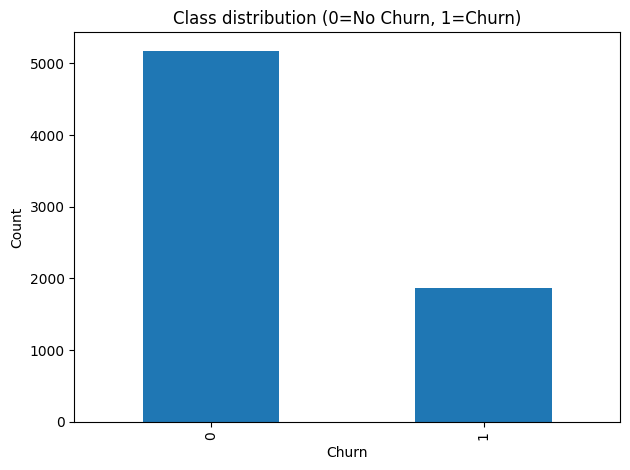

Saved: C:\Users\amobi\churn-prediction\reports\figures\class_distribution.png


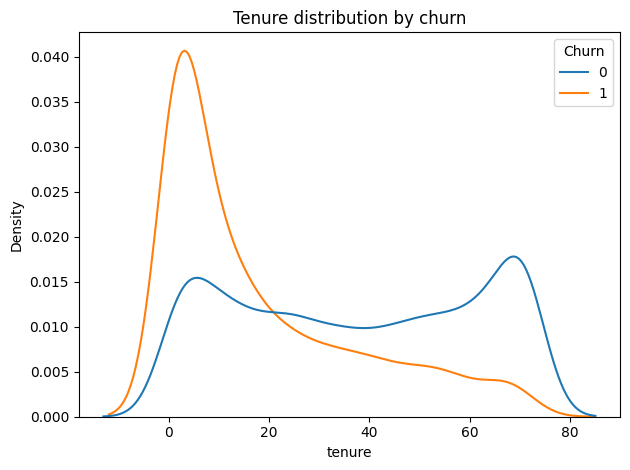

Saved: C:\Users\amobi\churn-prediction\reports\figures\tenure_by_churn.png


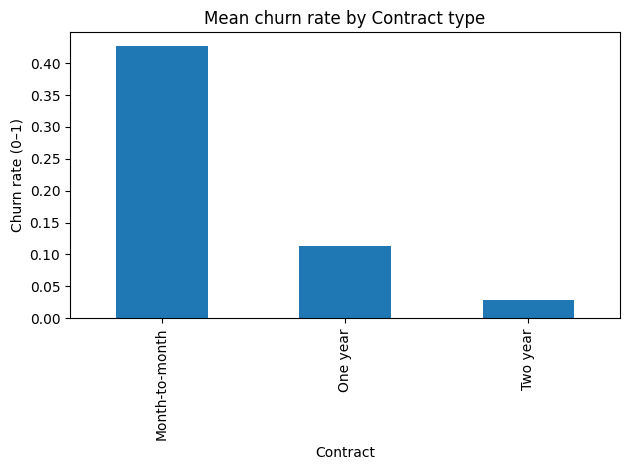

Saved: C:\Users\amobi\churn-prediction\reports\figures\churn_by_contract.png


In [4]:
# Ensure figure folder exists (from /notebooks path this climbs one level)
import os
FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# 1) Class distribution (0=no churn, 1=churn)
ax = df["Churn"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Class distribution (0=No Churn, 1=Churn)")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
fig_path1 = f"{FIG_DIR}/class_distribution.png"
plt.tight_layout(); plt.savefig(fig_path1, dpi=150); plt.show()
print("Saved:", os.path.abspath(fig_path1))

# 2) Tenure distribution by churn (if 'tenure' exists)
if "tenure" in df.columns:
    plt.figure()
    sns.kdeplot(data=df, x="tenure", hue="Churn", common_norm=False)
    plt.title("Tenure distribution by churn")
    plt.tight_layout()
    fig_path2 = f"{FIG_DIR}/tenure_by_churn.png"
    plt.savefig(fig_path2, dpi=150); plt.show()
    print("Saved:", os.path.abspath(fig_path2))
else:
    print("Skipped tenure plot: 'tenure' not found")

# 3) Churn rate by Contract type (if 'Contract' exists)
if "Contract" in df.columns:
    plt.figure()
    (df.groupby("Contract")["Churn"].mean()
       .sort_values(ascending=False)
       .plot(kind="bar"))
    plt.title("Mean churn rate by Contract type")
    plt.ylabel("Churn rate (0–1)")
    plt.tight_layout()
    fig_path3 = f"{FIG_DIR}/churn_by_contract.png"
    plt.savefig(fig_path3, dpi=150); plt.show()
    print("Saved:", os.path.abspath(fig_path3))
else:
    print("Skipped contract plot: 'Contract' not found")

## Project Questions (v1)
- What is the baseline churn rate and class imbalance? *(Observed: ~26.5% churners.)*
- Which features are most predictive of churn (e.g., tenure, contract type, charges)?
- Are there data quality issues (e.g., `TotalCharges` blanks) that need imputing?
- What baseline model should we use (logistic vs tree), and which metric matters most (ROC AUC, recall for churn class)?
- How do we avoid leakage and overfitting (fit all transforms inside a pipeline; stratified split; cross-validation)?

## Initial Observations (from quick EDA)
- **Imbalance:** Churners are the minority (~26.5%) → accuracy alone is misleading.
- **Tenure:** Churners skew to **lower tenure** (new customers leave earlier).
- **Contract:** **Month-to-month** has the highest churn rate; **Two year** the lowest (expected).
- **Caution:** Tenure and contract are correlated; don’t over-interpret causality from these plots.


In [5]:
# Rehydrate Step 1 essentials so df exists in memory
import os, numpy as np, pandas as pd

DATA_PATH = "../data/raw/telco_churn.csv"
assert os.path.exists(DATA_PATH), f"CSV not found: {os.path.abspath(DATA_PATH)}"

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

# Target normalization
df["Churn"] = (
    df["Churn"].astype(str).str.strip().str.title().map({"Yes": 1, "No": 0})
)

# TotalCharges → numeric with blanks -> NaN
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(
        df["TotalCharges"].astype(str).str.strip().replace({"": np.nan}),
        errors="coerce"
    )

print("Rehydrated df:", df.shape,
      "| Churn dtype:", df["Churn"].dtype,
      "| TotalCharges dtype:", df.get("TotalCharges", pd.Series(dtype=float)).dtype)


Rehydrated df: (7043, 21) | Churn dtype: int64 | TotalCharges dtype: float64


In [6]:
TARGET = "Churn"
drop_cols = ["customerID"]

X = df.drop(columns=drop_cols + [TARGET])
y = df[TARGET].astype(int)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Columns now (first 12):", X.columns[:12].tolist())


X shape: (7043, 19) | y shape: (7043,)
Columns now (first 12): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']


In [7]:
# Identify numeric vs categorical
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Number of categorical columns:", len(cat_cols))
print("First 10 categorical:", cat_cols[:10])

# Cardinality of categoricals (high cardinality can be risky with OHE)
cardinality = X[cat_cols].nunique().sort_values(ascending=False)
print("\nTop-10 categorical cardinalities:")
print(cardinality.head(10))

# Quick dtype confirmation for the known gotcha
if "TotalCharges" in X.columns:
    print("\nTotalCharges dtype:", X["TotalCharges"].dtype)

# Flag anything suspicious (e.g., > 50 unique categories)
high_card = cardinality[cardinality > 50]
print("\nHigh-cardinality categoricals (>50 unique):")
print(high_card if len(high_card) else "None")

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Number of categorical columns: 15
First 10 categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

Top-10 categorical cardinalities:
PaymentMethod       4
InternetService     3
OnlineSecurity      3
DeviceProtection    3
TechSupport         3
OnlineBackup        3
MultipleLines       3
StreamingTV         3
StreamingMovies     3
Contract            3
dtype: int64

TotalCharges dtype: float64

High-cardinality categoricals (>50 unique):
None


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric: fill gaps with median (robust to outliers) then scale (helps linear models)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: fill gaps with most common value then one-hot encode
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# Column-wise assembly: applies the right pipe to the right columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

preprocess


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1) Split with stratification on the target
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 2) Fit the preprocessor on TRAIN ONLY; then transform both
Xt_tr = preprocess.fit_transform(X_tr)
Xt_te = preprocess.transform(X_te)

print("Train split shapes:", X_tr.shape, y_tr.shape)
print("Transformed shapes:", Xt_tr.shape, Xt_te.shape)

# 3) Try to fetch feature names (works on recent scikit-learn)
try:
    feature_names = preprocess.get_feature_names_out()
    print("Feature count:", len(feature_names))
    print("First 12 features:", feature_names[:12])
except Exception as e:
    print("Feature names unavailable:", repr(e))

# 4) Check for NaNs after transform (support sparse matrices)
def has_nan(mat):
    try:
        import scipy.sparse as sp
        if sp.issparse(mat):
            return np.isnan(mat.data).any()
        return np.isnan(mat).any()
    except Exception:
        return False

print("Any NaNs in Xt_tr?", has_nan(Xt_tr))
print("Any NaNs in Xt_te?", has_nan(Xt_te))


Train split shapes: (5634, 19) (5634,)
Transformed shapes: (5634, 45) (1409, 45)
Feature count: 45
First 12 features: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges'
 'num__TotalCharges' 'cat__gender_Female' 'cat__gender_Male'
 'cat__Partner_No' 'cat__Partner_Yes' 'cat__Dependents_No'
 'cat__Dependents_Yes' 'cat__PhoneService_No' 'cat__PhoneService_Yes']
Any NaNs in Xt_tr? False
Any NaNs in Xt_te? False


In [10]:
# === Recovery: rebuild df -> X,y -> preprocess -> train/test splits ===
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

DATA_PATH = "../data/raw/telco_churn.csv"
assert os.path.exists(DATA_PATH), f"CSV not found: {os.path.abspath(DATA_PATH)}"

# 1) Rehydrate df if missing
if 'df' not in globals():
    df = pd.read_csv(DATA_PATH)
    df.columns = [c.strip() for c in df.columns]
    df["Churn"] = df["Churn"].astype(str).str.strip().str.title().map({"Yes": 1, "No": 0})
    if "TotalCharges" in df.columns:
        df["TotalCharges"] = pd.to_numeric(
            df["TotalCharges"].astype(str).str.strip().replace({"": np.nan}),
            errors="coerce"
        )

# 2) Features/target
TARGET = "Churn"
drop_cols = ["customerID"]
X = df.drop(columns=drop_cols + [TARGET])
y = df[TARGET].astype(int)

# 3) Type splits
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# 4) Preprocess pipelines
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# If you get: TypeError: OneHotEncoder got an unexpected keyword argument 'sparse_output'
# change 'sparse_output=True' to 'sparse=True'
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

# 5) Stratified split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Rebuilt preprocess & splits ✔")
print("X_tr/X_te shapes:", X_tr.shape, X_te.shape)
print("num:", num_cols, "\n#cat:", len(cat_cols))


Rebuilt preprocess & splits ✔
X_tr/X_te shapes: (5634, 19) (1409, 19)
num: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'] 
#cat: 15


ROC AUC: 0.841
              precision    recall  f1-score   support

           0      0.902     0.722     0.802      1035
           1      0.504     0.783     0.614       374

    accuracy                          0.738      1409
   macro avg      0.703     0.753     0.708      1409
weighted avg      0.797     0.738     0.752      1409



<Figure size 640x480 with 0 Axes>

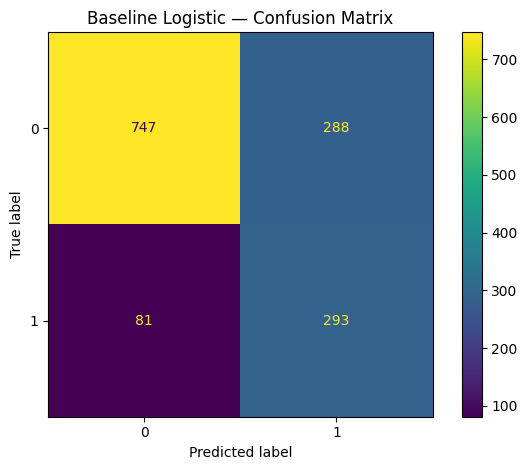

Saved: C:\Users\amobi\churn-prediction\reports\figures\confmat_baseline_logistic.png


<Figure size 640x480 with 0 Axes>

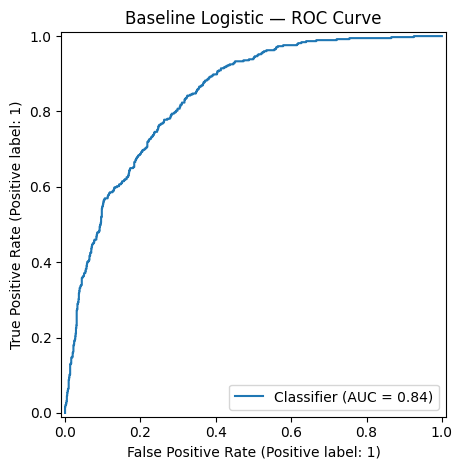

Saved: C:\Users\amobi\churn-prediction\reports\figures\roc_baseline_logistic.png
Metrics recorded at: C:\Users\amobi\churn-prediction\reports\metrics.json


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt, os, json
from pathlib import Path

# 1) Build the baseline pipeline = preprocess (already fit/defined) + logistic model
baseline = Pipeline(steps=[
    ("pre", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# 2) Fit on TRAIN, evaluate on TEST
baseline.fit(X_tr, y_tr)

proba = baseline.predict_proba(X_te)[:, 1]        # churn probability
pred  = (proba >= 0.50).astype(int)               # default 0.5 threshold for now

# 3) Metrics
auc = roc_auc_score(y_te, proba)
report = classification_report(y_te, pred, digits=3, output_dict=False)
print("ROC AUC:", round(auc, 3))
print(report)

# 4) Save plots
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_te, pred)
plt.title("Baseline Logistic — Confusion Matrix")
cm_path = FIG_DIR / "confmat_baseline_logistic.png"
plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.show()
print("Saved:", cm_path.resolve())

plt.figure()
RocCurveDisplay.from_predictions(y_te, proba)
plt.title("Baseline Logistic — ROC Curve")
roc_path = FIG_DIR / "roc_baseline_logistic.png"
plt.tight_layout(); plt.savefig(roc_path, dpi=150); plt.show()
print("Saved:", roc_path.resolve())

# 5) Persist key metrics for the README
METRICS_PATH = Path("../reports/metrics.json")
metrics = {"baseline_logistic": {"roc_auc": float(auc)}}
# merge if file exists
if METRICS_PATH.exists():
    try:
        with open(METRICS_PATH) as f:
            existing = json.load(f)
    except Exception:
        existing = {}
    existing.update(metrics)
    with open(METRICS_PATH, "w") as f:
        json.dump(existing, f, indent=2)
else:
    with open(METRICS_PATH, "w") as f:
        json.dump(metrics, f, indent=2)

print("Metrics recorded at:", METRICS_PATH.resolve())


Best F1(threshold) for churn class: F1=0.622 at threshold=0.540

Classification report @best threshold
              precision    recall  f1-score   support

           0      0.898     0.749     0.817      1035
           1      0.524     0.765     0.622       374

    accuracy                          0.753      1409
   macro avg      0.711     0.757     0.719      1409
weighted avg      0.799     0.753     0.765      1409



<Figure size 640x480 with 0 Axes>

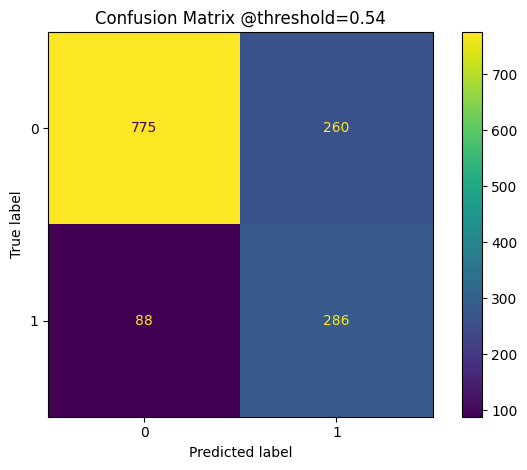

Saved: C:\Users\amobi\churn-prediction\reports\figures\confmat_logistic_bestF1.png


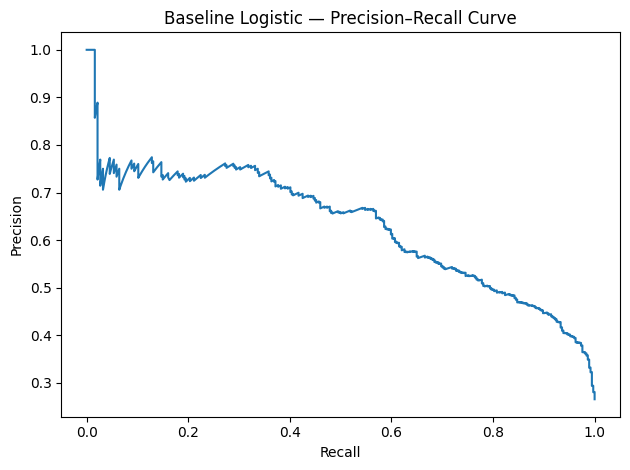

Saved: C:\Users\amobi\churn-prediction\reports\figures\prcurve_baseline_logistic.png


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure we have proba from the baseline fit; if not, recompute:
try:
    _ = proba[:3]
except NameError:
    proba = baseline.predict_proba(X_te)[:, 1]

# 1) Precision–Recall curve and best F1 threshold
prec, rec, thresh = precision_recall_curve(y_te, proba)
f1s = []
ths = []

# precision_recall_curve returns n+1 points; thresholds has length n-1, so align carefully
for t in np.linspace(0.05, 0.95, 181):  # 0.05→0.95 in 0.005 steps
    pred_t = (proba >= t).astype(int)
    f1s.append(f1_score(y_te, pred_t, zero_division=0))
    ths.append(t)

best_idx = int(np.argmax(f1s))
best_t = float(ths[best_idx])
best_f1 = float(f1s[best_idx])

print(f"Best F1(threshold) for churn class: F1={best_f1:.3f} at threshold={best_t:.3f}")

# 2) Metrics at best threshold
pred_best = (proba >= best_t).astype(int)
print("\nClassification report @best threshold")
print(classification_report(y_te, pred_best, digits=3))

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_te, pred_best)
plt.title(f"Confusion Matrix @threshold={best_t:.2f}")
FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
cm_best_path = FIG_DIR / "confmat_logistic_bestF1.png"
plt.tight_layout(); plt.savefig(cm_best_path, dpi=150); plt.show()
print("Saved:", cm_best_path.resolve())

# 3) Save PR curve (for README)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Baseline Logistic — Precision–Recall Curve")
pr_path = FIG_DIR / "prcurve_baseline_logistic.png"
plt.tight_layout(); plt.savefig(pr_path, dpi=150); plt.show()
print("Saved:", pr_path.resolve())


CV AUC:    0.837 ± 0.009
CV recall: 0.640 ± 0.024

Test ROC AUC: 0.834

Classification report @0.50 threshold
              precision    recall  f1-score   support

           0      0.866     0.828     0.846      1035
           1      0.575     0.644     0.608       374

    accuracy                          0.779      1409
   macro avg      0.720     0.736     0.727      1409
weighted avg      0.789     0.779     0.783      1409



<Figure size 640x480 with 0 Axes>

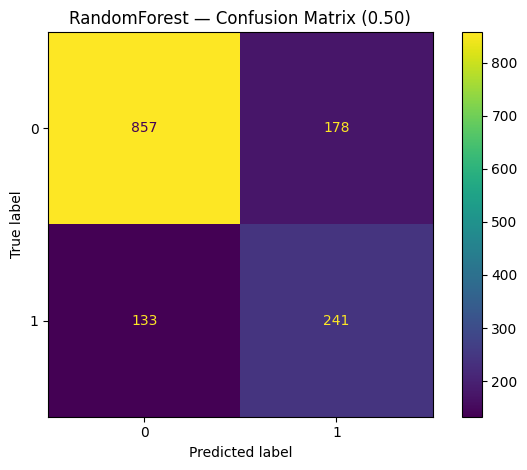

Saved: C:\Users\amobi\churn-prediction\reports\figures\confmat_rf_default.png


<Figure size 640x480 with 0 Axes>

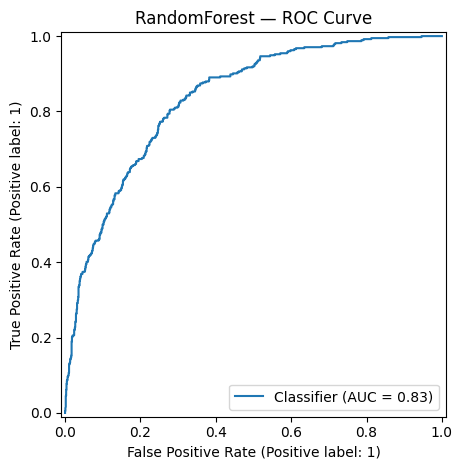

Saved: C:\Users\amobi\churn-prediction\reports\figures\roc_rf.png


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# 1) Define pipeline (same preprocess) + a sensible RF config for tabular data
rf = Pipeline(steps=[
    ("pre", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# 2) 5-fold CV on TRAIN (AUC and recall for churners)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc   = cross_val_score(rf, X_tr, y_tr, cv=cv, scoring="roc_auc")
cv_recall= cross_val_score(rf, X_tr, y_tr, cv=cv, scoring="recall")

print(f"CV AUC:    {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")
print(f"CV recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")

# 3) Fit on TRAIN, evaluate on TEST (default 0.50 threshold first)
rf.fit(X_tr, y_tr)
rf_proba = rf.predict_proba(X_te)[:, 1]
rf_pred  = (rf_proba >= 0.50).astype(int)

test_auc = roc_auc_score(y_te, rf_proba)
print("\nTest ROC AUC:", round(test_auc, 3))
print("\nClassification report @0.50 threshold")
print(classification_report(y_te, rf_pred, digits=3))

# 4) Save CM + ROC for the RF
FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_te, rf_pred)
plt.title("RandomForest — Confusion Matrix (0.50)")
cm_rf_path = FIG_DIR / "confmat_rf_default.png"
plt.tight_layout(); plt.savefig(cm_rf_path, dpi=150); plt.show()
print("Saved:", cm_rf_path.resolve())

plt.figure()
RocCurveDisplay.from_predictions(y_te, rf_proba)
plt.title("RandomForest — ROC Curve")
roc_rf_path = FIG_DIR / "roc_rf.png"
plt.tight_layout(); plt.savefig(roc_rf_path, dpi=150); plt.show()
print("Saved:", roc_rf_path.resolve())


RF best F1(threshold): F1=0.625 at threshold=0.385

Classification report @RF best threshold
              precision    recall  f1-score   support

           0      0.900     0.749     0.818      1035
           1      0.526     0.770     0.625       374

    accuracy                          0.754      1409
   macro avg      0.713     0.759     0.721      1409
weighted avg      0.801     0.754     0.766      1409



<Figure size 640x480 with 0 Axes>

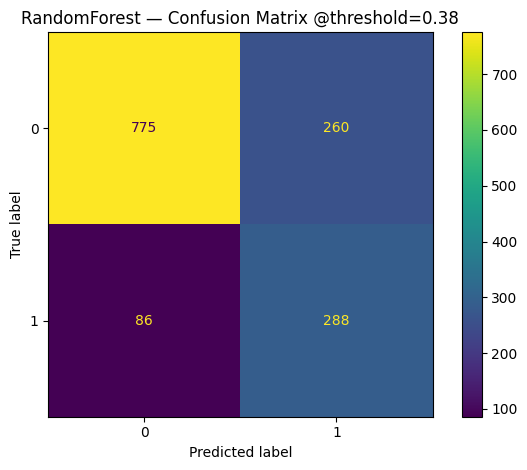

Saved: C:\Users\amobi\churn-prediction\reports\figures\confmat_rf_bestF1.png


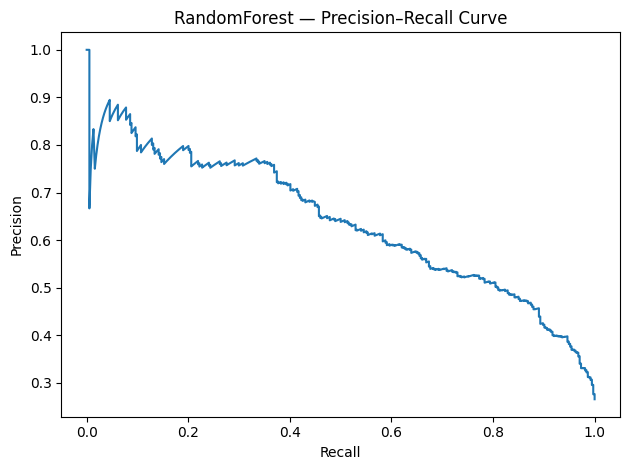

Saved: C:\Users\amobi\churn-prediction\reports\figures\prcurve_rf.png


In [14]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure rf_proba exists; if not, recompute
try:
    _ = rf_proba[:3]
except NameError:
    rf_proba = rf.predict_proba(X_te)[:, 1]

# Sweep thresholds and pick the one that maximises F1 for class 1
ths = np.linspace(0.05, 0.95, 181)
f1s = []
for t in ths:
    f1s.append(f1_score(y_te, (rf_proba >= t).astype(int), zero_division=0))

best_idx = int(np.argmax(f1s))
best_t = float(ths[best_idx])
best_f1 = float(f1s[best_idx])

print(f"RF best F1(threshold): F1={best_f1:.3f} at threshold={best_t:.3f}")

# Metrics at best threshold
rf_pred_best = (rf_proba >= best_t).astype(int)
print("\nClassification report @RF best threshold")
print(classification_report(y_te, rf_pred_best, digits=3))

# Save confusion matrix and PR curve
FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_te, rf_pred_best)
plt.title(f"RandomForest — Confusion Matrix @threshold={best_t:.2f}")
cm_rf_best_path = FIG_DIR / "confmat_rf_bestF1.png"
plt.tight_layout(); plt.savefig(cm_rf_best_path, dpi=150); plt.show()
print("Saved:", cm_rf_best_path.resolve())

# PR curve (for RF)
from sklearn.metrics import precision_recall_curve
prec_rf, rec_rf, _ = precision_recall_curve(y_te, rf_proba)
plt.figure()
plt.plot(rec_rf, prec_rf)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("RandomForest — Precision–Recall Curve")
pr_rf_path = FIG_DIR / "prcurve_rf.png"
plt.tight_layout(); plt.savefig(pr_rf_path, dpi=150); plt.show()
print("Saved:", pr_rf_path.resolve())


[LOG] AUC=0.841 | Best F1=0.622 @ threshold=0.540

Classification report @logistic best threshold
              precision    recall  f1-score   support

           0      0.898     0.749     0.817      1035
           1      0.524     0.765     0.622       374

    accuracy                          0.753      1409
   macro avg      0.711     0.757     0.719      1409
weighted avg      0.799     0.753     0.765      1409



<Figure size 640x480 with 0 Axes>

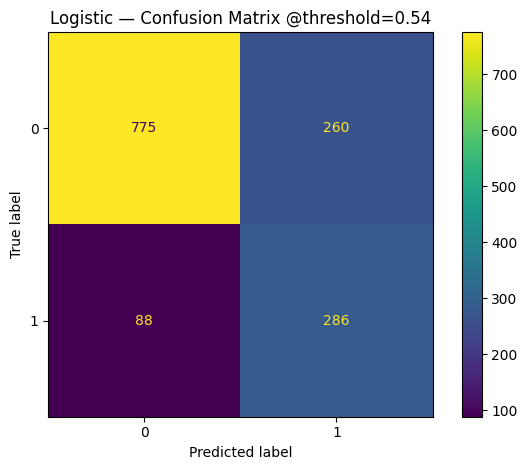

Saved: C:\Users\amobi\churn-prediction\reports\figures\confmat_logistic_bestF1_frozen.png


In [15]:
# Recompute logistic proba and best threshold so we freeze it under distinct names
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, ConfusionMatrixDisplay
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score

# 1) Ensure the trained logistic pipeline exists (baseline). If not, refit quickly.
try:
    baseline
except NameError:
    from sklearn.linear_model import LogisticRegression
    baseline = Pipeline(steps=[
        ("pre", preprocess),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ])
    baseline.fit(X_tr, y_tr)

# 2) Probabilities on test
log_proba = baseline.predict_proba(X_te)[:, 1]
auc_log = roc_auc_score(y_te, log_proba)

# 3) Sweep thresholds for best F1 on the churn class
ths = np.linspace(0.05, 0.95, 181)
f1s = [f1_score(y_te, (log_proba >= t).astype(int), zero_division=0) for t in ths]
best_idx = int(np.argmax(f1s))
log_best_t = float(ths[best_idx])
log_best_f1 = float(f1s[best_idx])

print(f"[LOG] AUC={auc_log:.3f} | Best F1={log_best_f1:.3f} @ threshold={log_best_t:.3f}")

# 4) Report & confusion matrix at the frozen threshold
log_pred_best = (log_proba >= log_best_t).astype(int)
print("\nClassification report @logistic best threshold")
print(classification_report(y_te, log_pred_best, digits=3))

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_te, log_pred_best)
plt.title(f"Logistic — Confusion Matrix @threshold={log_best_t:.2f}")
cm_log_best_path = FIG_DIR / "confmat_logistic_bestF1_frozen.png"
plt.tight_layout(); plt.savefig(cm_log_best_path, dpi=150); plt.show()
print("Saved:", cm_log_best_path.resolve())


In [16]:
from pathlib import Path
from datetime import datetime
import joblib, json, sys, sklearn

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save the fitted pipeline
pipe_path = MODELS_DIR / "logistic_pipeline.joblib"
joblib.dump(baseline, pipe_path)

# 2) Save the chosen decision threshold + metadata
try:
    feat_names = baseline.named_steps["pre"].get_feature_names_out()
    n_feats = int(len(feat_names))
except Exception:
    n_feats = None

meta = {
    "model": "logistic_regression",
    "threshold": float(log_best_t),
    "created_utc": datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "python": sys.version.split()[0],
    "sklearn": sklearn.__version__,
    "n_features": n_feats
}
th_path = MODELS_DIR / "threshold.json"
with open(th_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved pipeline  ->", pipe_path.resolve())
print("Saved threshold ->", th_path.resolve())
print("Metadata:", meta)


Saved pipeline  -> C:\Users\amobi\churn-prediction\models\logistic_pipeline.joblib
Saved threshold -> C:\Users\amobi\churn-prediction\models\threshold.json
Metadata: {'model': 'logistic_regression', 'threshold': 0.5399999999999999, 'created_utc': '2025-09-03T17:32:17Z', 'python': '3.12.4', 'sklearn': '1.7.1', 'n_features': 45}


C:\Users\amobi\AppData\Local\Temp\ipykernel_26280\2356065665.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.utcnow().isoformat(timespec="seconds") + "Z",


Saved coefficients CSV -> C:\Users\amobi\churn-prediction\reports\tables\logistic_coefficients.csv


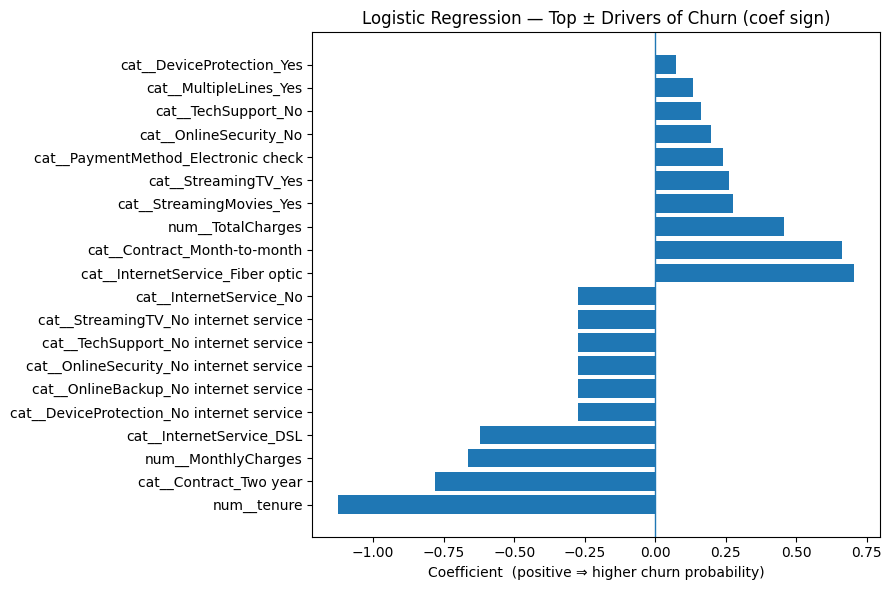

Saved top-features figure -> C:\Users\amobi\churn-prediction\reports\figures\logistic_top_features.png

Top +5 churn-increasing features:
                         feature     coef
cat__InternetService_Fiber optic 0.705336
    cat__Contract_Month-to-month 0.663399
               num__TotalCharges 0.457211
        cat__StreamingMovies_Yes 0.274978
            cat__StreamingTV_Yes 0.262038

Top +5 churn-reducing features:
                                  feature      coef
                              num__tenure -1.123589
                   cat__Contract_Two year -0.781257
                      num__MonthlyCharges -0.663581
                 cat__InternetService_DSL -0.621009
cat__DeviceProtection_No internet service -0.274568


In [17]:
# === Coefficients & Top Features for Logistic Regression ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

pre = baseline.named_steps["pre"]
logreg = baseline.named_steps["model"]

# 1) Get feature names after preprocessing (num + one-hot cats)
try:
    feat_names = pre.get_feature_names_out()
except Exception:
    # Fallback if using older sklearn
    num_cols = pre.transformers_[0][2]
    ohe = pre.named_transformers_["cat"].named_steps["ohe"]
    cat_cols = pre.transformers_[1][2]
    feat_names = np.r_[ [f"num__{c}" for c in num_cols],
                        ohe.get_feature_names_out(cat_cols) ]

# 2) Collect coefficients (1 x n) and compute helper columns
coefs = logreg.coef_.ravel()
coef_df = pd.DataFrame({
    "feature": feat_names,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["odds_ratio"] = np.exp(coef_df["coef"])  # interpretation: >1 ↑ churn odds

# 3) Save full table
TABLE_DIR = Path("../reports/tables"); TABLE_DIR.mkdir(parents=True, exist_ok=True)
csv_path = TABLE_DIR / "logistic_coefficients.csv"
coef_df.sort_values("abs_coef", ascending=False).to_csv(csv_path, index=False)
print("Saved coefficients CSV ->", csv_path.resolve())

# 4) Plot top +/- drivers
TOP = 10
pos = coef_df.sort_values("coef", ascending=False).head(TOP)
neg = coef_df.sort_values("coef", ascending=True).head(TOP)
plot_df = pd.concat([neg, pos])

plt.figure(figsize=(9, 6))
plt.barh(plot_df["feature"], plot_df["coef"])
plt.axvline(0, linewidth=1)
plt.title("Logistic Regression — Top ± Drivers of Churn (coef sign)")
plt.xlabel("Coefficient  (positive ⇒ higher churn probability)")
plt.tight_layout()

FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
fig_path = FIG_DIR / "logistic_top_features.png"
plt.savefig(fig_path, dpi=150); plt.show()
print("Saved top-features figure ->", fig_path.resolve())

# 5) Quick textual summary for README drafting
print("\nTop +5 churn-increasing features:")
print(pos[["feature","coef"]].head(5).to_string(index=False))
print("\nTop +5 churn-reducing features:")
print(neg[["feature","coef"]].head(5).to_string(index=False))


names: 19 | importances: (19,)
Saved permutation importance CSV -> C:\Users\amobi\churn-prediction\reports\tables\perm_importance_auc.csv


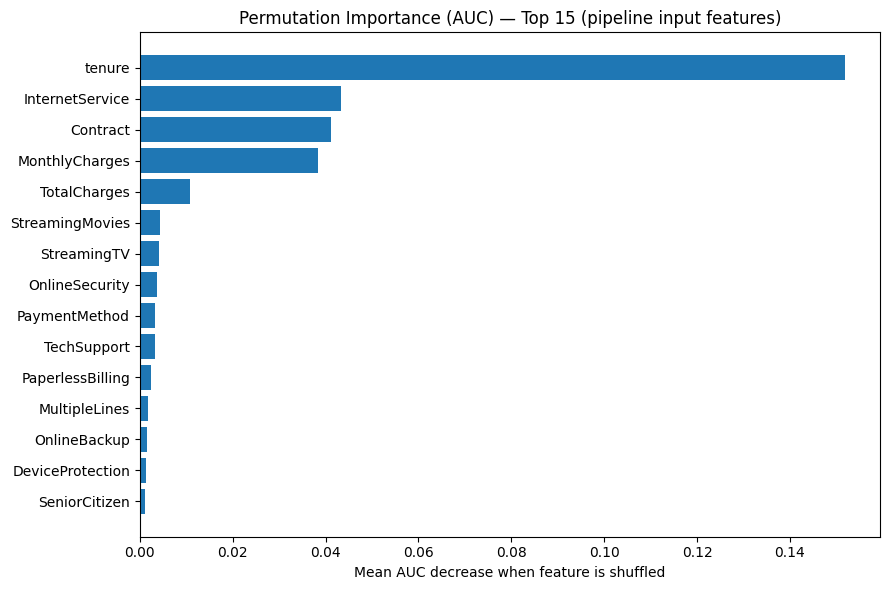

Saved permutation importance figure -> C:\Users\amobi\churn-prediction\reports\figures\perm_importance_auc_top15.png

Head of perm importance:
        feature  mean_auc_drop  std_auc_drop
         tenure       0.151821      0.007559
InternetService       0.043228      0.006589
       Contract       0.041226      0.004329
 MonthlyCharges       0.038476      0.005429
   TotalCharges       0.010814      0.002849
StreamingMovies       0.004345      0.001814
    StreamingTV       0.004078      0.002603
 OnlineSecurity       0.003727      0.001565


In [18]:
from sklearn.inspection import permutation_importance
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# Compute permutation importance on the PIPELINE (acts on raw columns)
perm = permutation_importance(
    baseline, X_te, y_te,
    scoring="roc_auc", n_repeats=20, random_state=42, n_jobs=-1
)

# Use the INPUT column names (19), not encoded names (45)
feat_names = list(X_te.columns)

# Sanity check: both should be same length
print("names:", len(feat_names), "| importances:", perm.importances_mean.shape)

imp_df = pd.DataFrame({
    "feature": feat_names,
    "mean_auc_drop": perm.importances_mean,
    "std_auc_drop": perm.importances_std
}).sort_values("mean_auc_drop", ascending=False)

# Save table and figure
TABLE_DIR = Path("../reports/tables"); TABLE_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

perm_csv = TABLE_DIR / "perm_importance_auc.csv"
imp_df.to_csv(perm_csv, index=False)
print("Saved permutation importance CSV ->", perm_csv.resolve())

topN = 15
plot_df = imp_df.head(topN)[::-1]
plt.figure(figsize=(9,6))
plt.barh(plot_df["feature"], plot_df["mean_auc_drop"])
plt.xlabel("Mean AUC decrease when feature is shuffled")
plt.title("Permutation Importance (AUC) — Top 15 (pipeline input features)")
plt.tight_layout()
perm_fig = FIG_DIR / "perm_importance_auc_top15.png"
plt.savefig(perm_fig, dpi=150); plt.show()
print("Saved permutation importance figure ->", perm_fig.resolve())

print("\nHead of perm importance:")
print(imp_df.head(8).to_string(index=False))


In [20]:
# src/predict.py
import json
import argparse
from pathlib import Path
from datetime import datetime, timezone

import joblib
import pandas as pd

# --- Resolve project root (works both as .py and in notebooks) ---
def _project_root() -> Path:
    try:
        return Path(__file__).resolve().parents[1]
    except NameError:
        # If executed from notebooks/, cwd is notebooks → parent is project root
        return Path.cwd().resolve().parent

PROJECT_ROOT = _project_root()
MODEL_PATH = PROJECT_ROOT / "models" / "logistic_pipeline.joblib"
THRESHOLD_PATH = PROJECT_ROOT / "models" / "threshold.json"

# Columns expected by the pipeline (same order doesn’t matter; names do)
FEATURES = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
    "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges",
]

def _load_threshold(default: float = 0.5) -> float:
    try:
        meta = json.loads(THRESHOLD_PATH.read_text(encoding="utf-8"))
        return float(meta.get("threshold", default))
    except Exception:
        return default

def _payload_to_df(payload: dict) -> pd.DataFrame:
    # Ensure every expected key exists; missing become None and will be imputed
    row = {k: payload.get(k) for k in FEATURES}
    return pd.DataFrame([row])

def main(argv=None):
    parser = argparse.ArgumentParser(description="Predict churn probability for one customer JSON.")
    parser.add_argument("-i", "--input", type=str, help="Path to JSON payload with customer attributes")
    parser.add_argument("-o", "--out", type=str, help="Optional path to save JSON result")
    args = parser.parse_args(argv)

    # Load artefacts
    pipe = joblib.load(MODEL_PATH)
    threshold = _load_threshold(0.5)

    # 1) Define the required input fields
    required = {
        "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges",
        "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
        "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
        "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
        "PaperlessBilling", "PaymentMethod",
    }

    # 2) If no input file is given, use a built-in example (a likely churner)
    if args.input:
        payload = json.loads(Path(args.input).read_text(encoding="utf-8-sig"))
    else:
        payload = {
            "gender": "Male", "SeniorCitizen": 0, "Partner": "No", "Dependents": "No",
            "tenure": 2, "PhoneService": "Yes", "MultipleLines": "No",
            "InternetService": "Fiber optic", "OnlineSecurity": "No", "OnlineBackup": "No",
            "DeviceProtection": "No", "TechSupport": "No", "StreamingTV": "Yes",
            "StreamingMovies": "Yes", "Contract": "Month-to-month",
            "PaperlessBilling": "Yes", "PaymentMethod": "Electronic check",
            "MonthlyCharges": 85.0, "TotalCharges": 190.0,
        }

    # 3) Validate that all required fields are present
    missing = required - payload.keys()
    if missing:
        raise SystemExit(
            f"Input is missing fields: {sorted(missing)[:5]}{' …' if len(missing) > 5 else ''}"
        )
    
    # 4) Predict
    X = _payload_to_df(payload)
    prob = float(pipe.predict_proba(X)[0, 1])
    pred = int(prob >= threshold)

    result = {
        "when_utc": datetime.now(timezone.utc).isoformat(timespec="seconds"),
        "threshold": round(threshold, 4),
        "prob_churn": round(prob, 4),
        "churn_pred": pred,
        "input": payload,
    }

    print(json.dumps(result, indent=2))
    if args.out:
        outp = Path(args.out)
        outp.parent.mkdir(parents=True, exist_ok=True)
        outp.write_text(json.dumps(result, indent=2), encoding="utf-8")

import sys
if __name__ == "__main__" and "ipykernel" not in sys.modules:
    main()
